In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv', index_col=['PassengerId'])
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.shape

(891, 11)

In [4]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
data.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Типы столбцов

Исправлю пол

In [6]:
data['Sex'] = (data.Sex == 'male').astype('int')

## Пустые значения

In [7]:
data.isna().sum()/891.

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Поле `Cabin` невозможно заполнить - слишком много пропущенных

`Embarked`, `Age` - нужно работать

# Возраст (`Age`)

## Анализ

In [8]:
data_temp = data.copy()
data_temp['AgeNA'] = data.Age.isna()

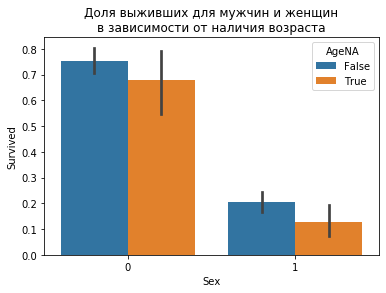

In [9]:
sns.barplot(data=data_temp, y='Survived', x='Sex', hue='AgeNA')
plt.title('Доля выживших для мужчин и женщин\nв зависимости от наличия возраста');

NaN возраст понижает шансы выжить, но не сильно, поэтому **заменю возраст на средний по классу** (можно попытаться восстановить возраст из имени)

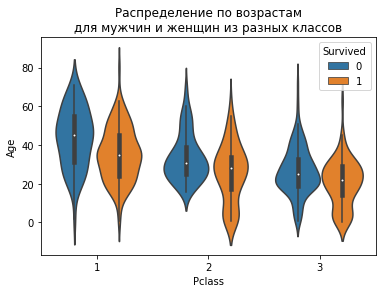

In [10]:
sns.violinplot(x="Pclass", y="Age", hue='Survived', data=data_temp)
plt.title('Распределение по возрастам\nдля мужчин и женщин из разных классов');

Детей выжило больше, стариков - меньше

## Замена

In [11]:
def replace_age(data):
    ages = data.groupby('Pclass').agg({'Age':np.median}).rename({'Age':'MedianAge'}, axis=1)
    data = data.merge(ages, on='Pclass')
    data.Age.fillna(data.MedianAge, inplace=True)
    data.drop(['MedianAge'], axis=1, inplace=True)
    return data

In [12]:
data = replace_age(data)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
2,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S
3,0,3,"Moran, Mr. James",1,24.0,0,0,330877,8.4583,NaN,Q
4,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S


# Имена (`Name`)

## Анализ

In [13]:
data_temp = data.copy()

In [14]:
import re
names_str = ' '.join( data_temp.Name.values )
names = re.findall(r'\w+', names_str)

In [15]:
dfNames = pd.DataFrame({'name': np.unique(names, return_counts=True)[0], 'count':
                  np.unique(names, return_counts=True)[1]}).\
sort_values(by='count', ascending=False).reset_index().drop(['index'], axis=1)

In [16]:
dfNames.loc[0:10]

,name,count
0,Mr,521
1,Miss,182
2,Mrs,129
3,William,64
4,John,44
5,Master,40
6,Henry,35
7,James,24
8,Charles,24
9,George,24


Видно, что основная чась приходится на `Mr`, `Miss`, `Mrs` — эти имена надо учесть

\+ учесть `Master` — относится к детям

Интересно посмотреть, как имена сказываются на шансах на выживание

In [17]:
data_Mr = data_temp[data_temp.Name.str.find('Mr.')>-1]
data_Mrs = data_temp[data_temp.Name.str.find('Mrs.')>-1]
data_Miss = data_temp[data_temp.Name.str.find('Miss')>-1]
data_Master = data_temp[data_temp.Name.str.find('Master')>-1]

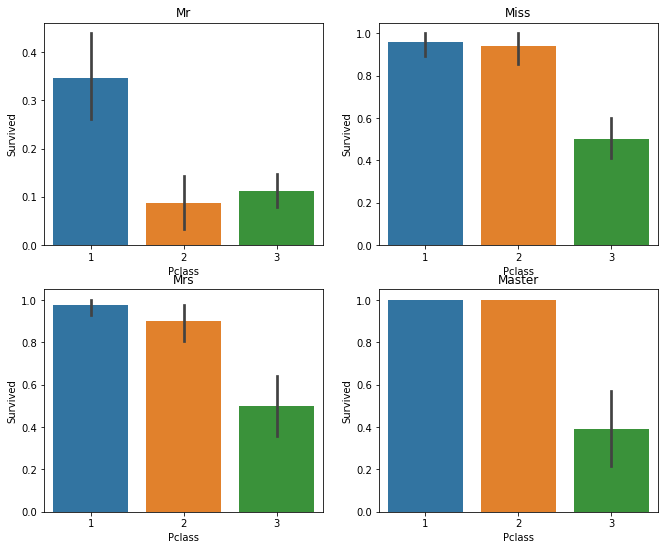

In [18]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(11,9)

data_Mr = data[data.Name.str.find('Mr.')>-1]
sns.barplot(data=data_Mr, x='Pclass', y='Survived', ax=ax[0,0])
ax[0,0].set_title('Mr')

sns.barplot(data=data_Mrs, x='Pclass', y='Survived', ax=ax[1,0])
ax[1,0].set_title('Mrs')

sns.barplot(data=data_Miss, x='Pclass', y='Survived', ax=ax[0,1])
ax[0,1].set_title('Miss')

sns.barplot(data=data_Master, x='Pclass', y='Survived', ax=ax[1,1])
ax[1,1].set_title('Master');

Можно посмотреть распределение по возрастам для типов имён

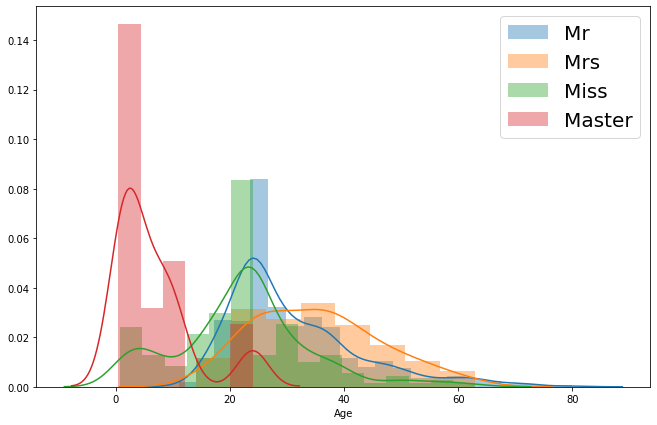

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11,7)

sns.distplot(data_Mr.Age, label='Mr')
sns.distplot(data_Mrs.Age, label='Mrs')
sns.distplot(data_Miss.Age, label='Miss')
sns.distplot(data_Master.Age, label='Master')
plt.legend(fontsize=20);

`Master` действительно преимущественно дети (возможно тот, который оказался постарше, пришёл из заполненного NaN значения)

И естественное предположение, что `Miss` помоложе и `Mrs` постарше подтвердилось

Теперь надо закодировать имена в числовые переменные

## Замена

In [20]:
def replace_name(dataOne):
    data = dataOne.copy()
    data['Name_Mr'] = (data.Name.str.find('Mr.')>-1).astype('int')
    data['Name_Mrs'] = (data.Name.str.find('Mrs.')>-1).astype('int')
    data['Name_Miss'] = (data.Name.str.find('Miss')>-1).astype('int')
    data['Name_Master'] = (data.Name.str.find('Master')>-1).astype('int')
    data.drop(['Name'], axis=1, inplace=True)
    return data

In [21]:
data = replace_name(data)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_Mr,Name_Mrs,Name_Miss,Name_Master
0,0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,0,0
1,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0
2,0,3,1,35.0,0,0,373450,8.0500,NaN,S,1,0,0,0
3,0,3,1,24.0,0,0,330877,8.4583,NaN,Q,1,0,0,0
4,0,3,1,2.0,3,1,349909,21.0750,NaN,S,0,0,0,1


# Кабина (`Cabin`)

## Анализ

Куча кабин не определены, поэтому заполнить их чем-то правдоподобным нереально.

Но можно проследить, есть ли связь между записью в поле и выживаемостью

In [22]:
data_temp = data.copy()

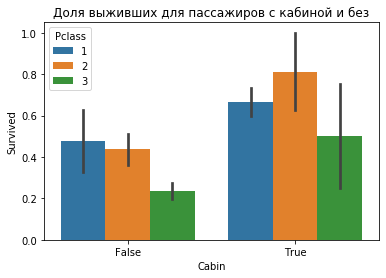

In [23]:
sns.barplot( x=(data_temp.Cabin.isna()==False), y=data_temp.Survived, hue=data_temp.Pclass)
plt.title('Доля выживших для пассажиров с кабиной и без');

Пассажиры, у которых определена кабина выживают чаще, причём, больше определённых кабин для пассажиров 1го класса

Так и определю: либо есть, либо нет

## Замена

In [24]:
def replace_cabin(data):
    data_n = data.copy()
    data_n['isCabin'] = (data_n.Cabin.isna() == False).astype('int')
    data_n.drop(['Cabin'], axis=1, inplace=True)
    return data_n

In [25]:
data = replace_cabin(data)

# Место посадки (`Embarked`)

## Анализ

Проверить, как место посадки влияет на то, выжил ли пассажир - кажется, что не должно влиять

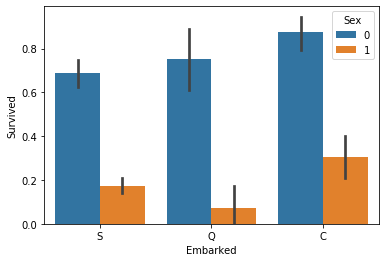

In [29]:
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=data)

Ок, разницы с учётом ошибок практически никакой, поэтому просто удаляю этот столбец из рассмотрения

## Замена

In [31]:
def replace_embarked(data):
    data_n = data.copy()
    data_n.drop(['Embarked'], axis=1, inplace=True)
    return data_n

In [33]:
data = replace_embarked(data)

# Билеты (`Ticket`)

Просто выключу из рассмотрения

In [34]:
data.drop(['Ticket'], axis=1, inplace=True)

# Семья (`SibSp`, `Parch`)

В первом приближении вместо этих двух фич создам одну `isFamily`, которая указывает, есть ли родственники на корабле

In [40]:
def replace_family(data):
    data_n = data.copy()
    data_n['isFamily'] = ((data_n.Parch)|(data_n.SibSp>0)).astype('int')
    data_n.drop(['SibSp','Parch'], axis=1, inplace=True)
    return data_n

In [42]:
data = replace_family(data)

# Финальные данные

In [394]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Name_Mr,Name_Mrs,Name_Miss,Name_Master,isCabin,isFamily
0,0,3,1,22.0,7.2500,1,0,0,0,0,1
1,1,3,0,26.0,7.9250,0,0,1,0,0,0
2,0,3,1,35.0,8.0500,1,0,0,0,0,0
3,0,3,1,24.0,8.4583,1,0,0,0,0,0
4,0,3,1,2.0,21.0750,0,0,0,1,0,1


## Разделяю на train и test части

In [399]:
X, y = data.drop(['Survived'], axis=1), data.Survived
Xdata_train, Xdata_test, ydata_train, ydata_test = train_test_split(X, y, random_state=55, test_size=0.05)
Xdata_train.shape, Xdata_test.shape, ydata_train.shape, ydata_test.shape

((846, 10), (45, 10), (846,), (45,))

# Neural network

## Доподготовка данных

Нормализую фичи

In [400]:
m = X.mean()
s = X.std()
Xdata_train = (Xdata_train - m)/s
Xdata_test  = (Xdata_test  - m)/s

Преобразую в тензорный тип для торча

In [401]:
X_train = torch.FloatTensor(Xdata_train.values)
X_test  = torch.FloatTensor(Xdata_test.values)

y_train = torch.LongTensor(ydata_train.values)
y_test  = torch.LongTensor(ydata_test.values)

Количество уникальных выходов

In [402]:
y.nunique()

2

Выход нейросети - один нейрон, указывающий выжил ли пассажир

## Создание сети

In [411]:
torch.manual_seed(42)
np.random.seed(42)

In [412]:
model = nn.Sequential(
    nn.Linear(X.shape[1], 10),
    nn.Sigmoid(),
    nn.Linear(10, 10),
    nn.Dropout(0.5),
    nn.Sigmoid(),
    nn.Linear(10, 2)
)

In [413]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-1)

In [414]:
def train(num_epoch):
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        model.train(True)
        #Loss
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train)
        train_losses.append( float(train_loss) )
        #zero grad
        optimizer.zero_grad()
        #back prop
        train_loss.backward()
        #update weigths
        optimizer.step()

        model.train(False)
        y_pred = model(X_test)
        test_loss = loss_fn(y_pred, y_test)
        test_losses.append( float(test_loss) )

    return train_losses, test_losses 

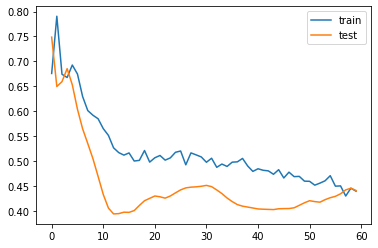

In [415]:
train_losses, test_losses = train(60)
plt.plot(range(len(train_losses)), train_losses, label='train')
plt.plot(range(len(test_losses)), test_losses, label='test')
plt.legend()

## Предсказания нашей сети

In [416]:
model(X_test);

In [417]:
y_pred1 = np.argmax( model(X_test).detach().numpy(), axis=1 )
y_test1 = y_test.numpy()

In [418]:
((y_pred1 == y_test1).sum())/y_pred1.size

0.8444444444444444

Ок, финальная точность 84.4%